In [ ]:
!pip install pandas

In [ ]:
!pip install openpyxl

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.filters.hp_filter import hpfilter
from scipy.optimize import minimize

In [ ]:
df = pd.read_excel('/content/DATA.xlsx')

In [ ]:
Y = df['Y'].values
C = df['C'].values
I = df['I'].values
K=  df['K'].values
N = df['N'].values
r = df['r'].values
w = df['w'].values

In [ ]:

for column in ['Y', 'C', 'I', 'N', 'r', 'w', 'K']:
    df[column] = df[column].astype(str).str.replace(',', '.').astype(float)

log_vars = ['Y', 'C', 'I', 'N', 'r', 'w', 'K']
for var in log_vars:
    df[var] = df[var].apply(lambda x: np.log(x) if x > 0 else np.nan)


for var in log_vars:
    if df[var].isna().sum() / len(df) > 0.5:
        print(f"Warning: Over 50% NaN values in {var} after log transformation.")

for var in log_vars:
    if df[var].isna().sum() / len(df) < 0.5:
        cycle, trend = hpfilter(df[var].dropna(), lamb=1600)
        df[var + '_cycle'] = cycle
    else:
        df[var + '_cycle'] = np.nan

def adf_test(series, title=''):
    if series.dropna().empty:
        return f'ADF Test: {title} - no non-NaN data available after preprocessing.\n'
    result = adfuller(series.dropna(), autolag='AIC')
    output = f'ADF Test: {title}\n'
    output += f'ADF Statistic: {result[0]}\n'
    output += f'p-value: {result[1]}\n'
    output += f'Num Lags: {result[2]}\n'
    output += f'Num Observations: {result[3]}\n'
    for key, value in result[4].items():
        output += f'Critical Value ({key}): {value}\n'
    return output

adf_results = {}
for var in log_vars:
    if df[var + '_cycle'].notna().any():
        adf_results[var] = adf_test(df[var + '_cycle'], title=var)

adf_results

{'C': 'ADF Test: C\nADF Statistic: -3.267315400553691\np-value: 0.016404208385478687\nNum Lags: 0\nNum Observations: 49\nCritical Value (1%): -3.5714715250448363\nCritical Value (5%): -2.922629480573571\nCritical Value (10%): -2.5993358475635153\n',
 'I': 'ADF Test: I\nADF Statistic: -2.540134521057029\np-value: 0.10601196926562628\nNum Lags: 0\nNum Observations: 49\nCritical Value (1%): -3.5714715250448363\nCritical Value (5%): -2.922629480573571\nCritical Value (10%): -2.5993358475635153\n',
 'N': 'ADF Test: N\nADF Statistic: -2.540134521057029\np-value: 0.10601196926562628\nNum Lags: 0\nNum Observations: 49\nCritical Value (1%): -3.5714715250448363\nCritical Value (5%): -2.922629480573571\nCritical Value (10%): -2.5993358475635153\n',
 'r': 'ADF Test: r\nADF Statistic: -3.0782621138537634\np-value: 0.028204276257109535\nNum Lags: 5\nNum Observations: 21\nCritical Value (1%): -3.7883858816542486\nCritical Value (5%): -3.013097747543462\nCritical Value (10%): -2.6463967573696143\n',
 

In [ ]:
beta = 0.99
alpha = 0.3
delta = 0.05


Optimization failed at t=3
Optimization failed at t=6
Optimization failed at t=9
Optimization failed at t=12
Optimization failed at t=15
Optimization failed at t=21
Optimization failed at t=30
Optimization failed at t=37
Optimization failed at t=38
Optimization failed at t=40
Optimization failed at t=41
Optimization failed at t=42
Optimization failed at t=43
Optimization failed at t=48


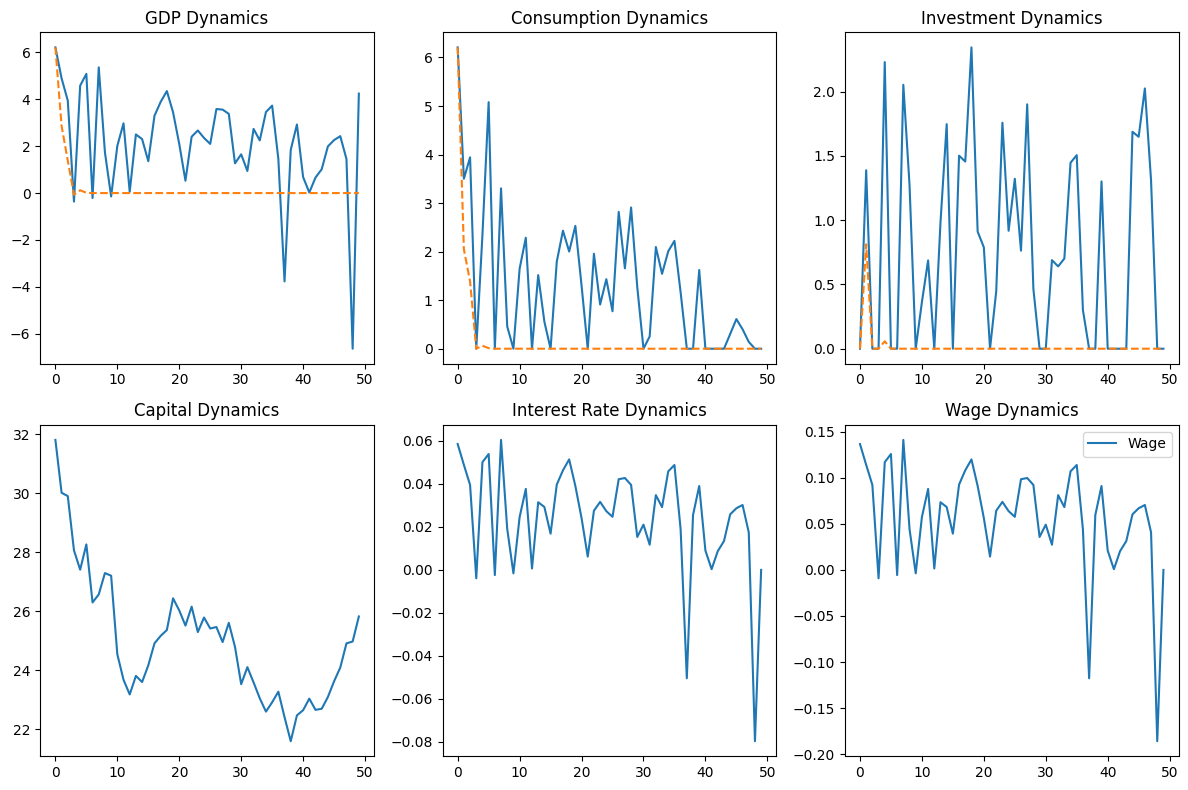

In [ ]:
# Simulate shocks
def simulate_shock(T):
    shocks = [1]
    std_shock = 0.02
    for t in range(1, T):
        shocks.append(shocks[-1] * np.random.lognormal(std_shock))
    return shocks

# Load your real data here, e.g., Y, alpha, beta, delta, N, and other model parameters

# Initialize lists to store results
C = np.zeros(len(Y))
I = np.zeros(len(Y))
K_new = np.zeros(len(Y))
r = np.zeros(len(Y))
w = np.zeros(len(Y))

# Simulate shocks
shocks = simulate_shock(len(Y))

# Solve the model using optimization
for t in range(len(Y)-1):
    # Calculate current values for r and w
    r[t] = alpha * Y[t] / K[t]
    w[t] = (1 - alpha) * Y[t] / N[t]

    # Apply shocks to parameters (e.g., technology shock)
    A_t = A[t] * shocks[t]  # Modify A with the shock

    # Optimize consumption and investment
    result = minimize(
        lambda x: -utility(x[0], beta),  # Loss function to maximize utility
        [1, 1],  # Initial guess for C and I
        constraints=(
            {'type': 'ineq', 'fun': lambda x: constraint1(x[0], x[1], w[t], N[t], r[t], K[t])},
            {'type': 'ineq', 'fun': lambda x: constraint2(K[t+1], x[1], K[t], delta)}
        ),
        bounds=((0, None), (0, None))  # C and I cannot be negative
    )

    # If optimization is successful, save the results
    if result.success:
        C[t], I[t] = result.x
    else:
        print(f"Optimization failed at t={t}")

# Results with shocks
plt.figure(figsize=(12, 8))

# GDP plot with shocks
plt.subplot(2, 3, 1)
plt.plot(Y, label='GDP')
plt.plot(Y * np.cumprod(shocks), label='GDP with Shocks', linestyle='--')
plt.title('GDP Dynamics')

# Consumption plot with shocks
plt.subplot(2, 3, 2)
plt.plot(C, label='Consumption')
plt.plot(C * np.cumprod(shocks), label='Consumption with Shocks', linestyle='--')
plt.title('Consumption Dynamics')

# Investment plot with shocks
plt.subplot(2, 3, 3)
plt.plot(I, label='Investment')
plt.plot(I * np.cumprod(shocks), label='Investment with Shocks', linestyle='--')
plt.title('Investment Dynamics')

# Capital plot
plt.subplot(2, 3, 4)
plt.plot(K, label='Capital')
plt.title('Capital Dynamics')

# Interest rate plot
plt.subplot(2, 3, 5)
plt.plot(r, label='Interest Rate')
plt.title('Interest Rate Dynamics')

# Wage plot
plt.subplot(2, 3, 6)
plt.plot(w, label='Wage')
plt.title('Wage Dynamics')

plt.tight_layout()
plt.legend()
plt.show()